In [1]:
from torch import nn
import torch, gym, gym_unbalanced_disk, time, gym.wrappers
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
from os import path

In [2]:
class Qfunction(nn.Module):
    def __init__(self, env):
        super(Qfunction,self).__init__()
        self.lay1 = nn.Linear(env.observation_space.shape[0], 40)
        self.F1 =  nn.Tanh() #a)
        self.lay2 = nn.Linear(40,env.action_space.n)
    
    def forward(self, obs):
        return self.lay2(self.F1(self.lay1(obs)))

In [3]:
def show(Q,env,setting):
    u = []
    theta = []
    omega = []
    with torch.no_grad():
        #you can use Qfun(obs) as a shorthand for the q function.
        Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy() #convert x to torch.tensor -> put in the Q function -> back to numpy
        try:
            obs = env.reset() #b)
            env.render() #b)
            time.sleep(1) #b)
            while True: #b)
                action = np.argmax(Qfun(obs)) #b)
                obs, reward, done, info = env.step(action) #b)
                time.sleep(1/60) #b)
                env.render() #b)
                if setting == "u":
                    print(env.u)
                elif setting == 'omega':
                    print(env.omega)
                elif setting == 'theta':
                    print(env.th)
                u.append(env.u)
                theta.append(env.th)
                omega.append(env.omega)
                if done: #b)
                    time.sleep(0.5)  #b)
                    break  #b)
        finally: #this will always run even when an error occurs
            env.close()
            return u,theta,omega

In [4]:
def rollout(Q, env, epsilon=0.1, N_rollout=10_000): 
    #save the following (use .append)
    Start_state = [] #hold an array of (x_t)
    Actions = [] #hold an array of (u_t)
    Rewards = [] #hold an array of (r_{t+1})
    End_state = [] #hold an array of (x_{t+1})
    Terminal = [] #hold an array of (terminal_{t+1})
    # Qfun( a numpy array of the obs) -> a numpy array of Q values
    Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy() 
    with torch.no_grad():
        
        obs = env.reset() #c)
        for i in range(N_rollout): #c)
            if np.random.uniform()>epsilon: #c)
                Qnow = Qfun(obs) #c)
                action = np.argmax(Qnow) #c)
            else: #c)
                action = env.action_space.sample() #c)
            Start_state.append(obs) #c)
            Actions.append(action) #c)

            obs_next, reward, done, info = env.step(action) #c)
            terminal = done and not info.get('TimeLimit.truncated', False) #c)

            Terminal.append(terminal) #c)
            Rewards.append(reward) #c)
            End_state.append(obs_next) #c)

            if done: #c)
                obs = env.reset() #c)
            else: #c)
                obs = obs_next #c)
                
    #error checking:
    assert len(Start_state)==len(Actions)==len(Rewards)==len(End_state)==len(Terminal), f'error in lengths: {len(Start_state)}=={len(Actions)}=={len(Rewards)}=={len(End_state)}=={len(Dones)}'
    return np.array(Start_state), np.array(Actions), np.array(Rewards), np.array(End_state), np.array(Terminal).astype(int)

In [5]:
def eval_Q(Q,env):
    with torch.no_grad():
        Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy()
        rewards_acc = 0 #d)
        obs = env.reset() #d)
        while True: #d)
            action = np.argmax(Qfun(obs)) #d)
            obs, reward, done, info = env.step(action) #d)
            rewards_acc += reward #d)
            if done: #d)
                return rewards_acc #d)

In [6]:
def DQN_rollout(Q, optimizer, env, gamma=0.98, use_target_net=False, N_iterations=21, N_rollout=20000, \
                N_epochs=10, batch_size=32, N_evals=10, target_net_update_feq=100):
    best = -float('inf')
    torch.save(Q.state_dict(),'Q-checkpoint')
    try:
        for iteration in range(N_iterations):
            epsilon = 1.0 - iteration/(N_iterations-1) #e=) 1.
            print(f'rollout iteration {iteration} with epsilon={epsilon:.2%}...')
            
            #2. rollout
            Start_state, Actions, Rewards, End_state, Dones = rollout(Q, env, epsilon=epsilon, N_rollout=N_rollout) #e) 2.
            
            #Data conversion, no changes required
            convert = lambda x: [torch.tensor(xi,dtype=torch.float32) for xi in x]
            Start_state, Rewards, End_state, Dones = convert([Start_state, Rewards, End_state, Dones])
            Actions = Actions.astype(int)

            print('starting training on rollout information...')
            t = 0
            for epoch in range(N_epochs): 
                for i in range(batch_size,len(Start_state)+1,batch_size): 
                    if t%target_net_update_feq==0:
                        Qtarget = deepcopy(Q) #g)
                        pass
                    t += 1
                    
                    Start_state_batch, Actions_batch, Rewards_batch, End_state_batch, Dones_batch = [d[i-batch_size:i] for d in [Start_state, Actions, Rewards, End_state, Dones]] #e=) 3.
                    
                    with torch.no_grad(): #3.
                        if use_target_net:
                            pass
                            maxQ = torch.max(Qtarget(End_state_batch),dim=1)[0] #g)
                        else:
                            maxQ = torch.max(Q(End_state_batch),dim=1)[0] #e=) 3.
                    
                    action_index = np.stack((np.arange(batch_size),Actions_batch),axis=0)
                    Qnow = Q(Start_state_batch)[action_index] #Q(x_t,u_t) is given
                    
                    Loss = torch.mean((Rewards_batch + gamma*maxQ*(1-Dones_batch) - Qnow)**2) #e) 3.
                    optimizer.zero_grad() #e) 3.
                    Loss.backward() #e) 3.
                    optimizer.step() #e) 3.
                
                score = np.mean([eval_Q(Q,env) for i in range(N_evals)]) #e=) 3.
                
                print(f'iteration={iteration} epoch={epoch} Average Reward per episode:',score)
                if score>best:
                    best = score
                    print('################################# \n new best',best,'saving Q... \n#################################')
                    torch.save(Q.state_dict(),'Q-checkpoint')
            
            print('loading best result')
            Q.load_state_dict(torch.load('Q-checkpoint'))
    finally: #this will always run even when using the a KeyBoard Interrupt. 
        print('loading best result')
        Q.load_state_dict(torch.load('Q-checkpoint'))

In [7]:
def save_Qfunction(Q):
    filename="Qfunction"
    torch.save(Q.state_dict(),filename)

    print(f'Saved Qfunction in {filename}')
    
def load_Qfunction(fileName):
    Qload = Qfunction(env)
    Qload.load_state_dict(torch.load(fileName))
    Qload.eval()
    return Qload

In [8]:
max_episode_steps = 300
env = gym.make('unbalanced-disk-sincos-v0', dt=0.025, umax=3.)
env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps)

target_angle = np.pi # target set to be balanced on top

angle_reward = lambda self: ((np.cos(self.th-target_angle)+1.5)**2 - 0.25)
correctVelocity_reward = lambda self: 0.00125*(((np.cos(self.th)+1)/2)*(self.omega)**2)
voltage_penalty = lambda self: -0.01*((self.u)**2)
# incorrectAngle_penalty = lambda self: -0.01*np.abs(self.th-target_angle)*np.abs(selft.th-target_angle) #EXPERIMENTEEL

reward_function = lambda self: angle_reward(self) + correctVelocity_reward(self) + voltage_penalty(self)

env.change_reward_function(reward_function)

env.set_discrete_values(discrete_size = 9, minmax = 3.0, div = 2.5, rnd = 2)

gamma = 0.98 #f=)
batch_size = 128 #f=)
N_iterations = 41 #f=)
N_rollout = 100000 #f=)
N_epochs = 60 #f=)
N_evals = 10 #f=)
lr = 0.0005 #given

assert isinstance(env.action_space,gym.spaces.Discrete), 'action space requires to be discrete'
Q = Qfunction(env)
optimizer = torch.optim.Adam(Q.parameters(),lr=lr) #low learning rate
DQN_rollout(Q, optimizer, env, use_target_net=True, gamma=gamma, N_iterations=N_iterations, \
            N_rollout=N_rollout, N_epochs=N_epochs, N_evals=N_evals)

Reward function changed
Discrete value set changed to [-3.0, -1.2, -0.48, -0.19, 0, 0.19, 0.48, 1.2, 3.0]
rollout iteration 0 with epsilon=100.00%...
starting training on rollout information...
iteration=0 epoch=0 Average Reward per episode: 19.671760435857152
################################# 
 new best 19.671760435857152 saving Q... 
#################################
iteration=0 epoch=1 Average Reward per episode: 30.548507945076114
################################# 
 new best 30.548507945076114 saving Q... 
#################################
iteration=0 epoch=2 Average Reward per episode: 41.89843983335772
################################# 
 new best 41.89843983335772 saving Q... 
#################################
iteration=0 epoch=3 Average Reward per episode: 649.6050486730794
################################# 
 new best 649.6050486730794 saving Q... 
#################################
iteration=0 epoch=4 Average Reward per episode: 122.03309402962066
iteration=0 epoch=5 Average Rew

iteration=1 epoch=47 Average Reward per episode: 75.17249070259263
iteration=1 epoch=48 Average Reward per episode: 75.21942781619555
iteration=1 epoch=49 Average Reward per episode: 75.15870583137198
iteration=1 epoch=50 Average Reward per episode: 5.376776709155439
iteration=1 epoch=51 Average Reward per episode: 288.731646421597
iteration=1 epoch=52 Average Reward per episode: 75.20784309954351
iteration=1 epoch=53 Average Reward per episode: 75.13879007179729
iteration=1 epoch=54 Average Reward per episode: 761.8561748902582
iteration=1 epoch=55 Average Reward per episode: 357.0202590639884
iteration=1 epoch=56 Average Reward per episode: 915.8421959400382
################################# 
 new best 915.8421959400382 saving Q... 
#################################
iteration=1 epoch=57 Average Reward per episode: 75.22679097690285
iteration=1 epoch=58 Average Reward per episode: 901.5416255777403
iteration=1 epoch=59 Average Reward per episode: 5.363564906278708
loading best result


iteration=3 epoch=35 Average Reward per episode: 440.22284695735937
iteration=3 epoch=36 Average Reward per episode: 75.20314995811259
iteration=3 epoch=37 Average Reward per episode: 422.3015624263232
iteration=3 epoch=38 Average Reward per episode: 585.4943300545568
iteration=3 epoch=39 Average Reward per episode: 730.174921883338
iteration=3 epoch=40 Average Reward per episode: 712.0507510767418
iteration=3 epoch=41 Average Reward per episode: 602.4314376313168
iteration=3 epoch=42 Average Reward per episode: 783.5879734947603
iteration=3 epoch=43 Average Reward per episode: 1009.7716771056679
iteration=3 epoch=44 Average Reward per episode: 75.21365782794504
iteration=3 epoch=45 Average Reward per episode: 75.20031840431216
iteration=3 epoch=46 Average Reward per episode: 75.2017528449791
iteration=3 epoch=47 Average Reward per episode: 75.24598500479244
iteration=3 epoch=48 Average Reward per episode: 75.16886159387448
iteration=3 epoch=49 Average Reward per episode: 75.1704859058

iteration=5 epoch=30 Average Reward per episode: 878.4906497418822
iteration=5 epoch=31 Average Reward per episode: 884.6983870381366
iteration=5 epoch=32 Average Reward per episode: 827.9385215592263
iteration=5 epoch=33 Average Reward per episode: 75.200400660053
iteration=5 epoch=34 Average Reward per episode: 75.14565143122334
iteration=5 epoch=35 Average Reward per episode: 75.21010442997593
iteration=5 epoch=36 Average Reward per episode: 75.22049759710976
iteration=5 epoch=37 Average Reward per episode: 75.183121304308
iteration=5 epoch=38 Average Reward per episode: 75.20115308437232
iteration=5 epoch=39 Average Reward per episode: 75.19806376345933
iteration=5 epoch=40 Average Reward per episode: 75.16390408654946
iteration=5 epoch=41 Average Reward per episode: 75.1684345918745
iteration=5 epoch=42 Average Reward per episode: 75.21158994694542
iteration=5 epoch=43 Average Reward per episode: 75.16621912920343
iteration=5 epoch=44 Average Reward per episode: 57.13980380717028


iteration=7 epoch=30 Average Reward per episode: 75.14187130418145
iteration=7 epoch=31 Average Reward per episode: 75.17564028380696
iteration=7 epoch=32 Average Reward per episode: 75.2026716891746
iteration=7 epoch=33 Average Reward per episode: 75.23119499562287
iteration=7 epoch=34 Average Reward per episode: 75.24506435856516
iteration=7 epoch=35 Average Reward per episode: 75.22386338963163
iteration=7 epoch=36 Average Reward per episode: 75.22502203715325
iteration=7 epoch=37 Average Reward per episode: 75.18680893178279
iteration=7 epoch=38 Average Reward per episode: 75.13013615674171
iteration=7 epoch=39 Average Reward per episode: 799.1059650117726
iteration=7 epoch=40 Average Reward per episode: 791.9490594215549
iteration=7 epoch=41 Average Reward per episode: 792.4563102416635
iteration=7 epoch=42 Average Reward per episode: 825.8604905040289
iteration=7 epoch=43 Average Reward per episode: 821.1245961134143
iteration=7 epoch=44 Average Reward per episode: 825.9002509079

iteration=9 epoch=27 Average Reward per episode: 75.18254254375168
iteration=9 epoch=28 Average Reward per episode: 864.3507784463603
iteration=9 epoch=29 Average Reward per episode: 936.5546639977629
iteration=9 epoch=30 Average Reward per episode: 75.19092425589608
iteration=9 epoch=31 Average Reward per episode: 75.18318679736655
iteration=9 epoch=32 Average Reward per episode: 1432.060110324139
iteration=9 epoch=33 Average Reward per episode: 1591.2124983618849
################################# 
 new best 1591.2124983618849 saving Q... 
#################################
iteration=9 epoch=34 Average Reward per episode: 75.1651525671954
iteration=9 epoch=35 Average Reward per episode: 859.5662770708174
iteration=9 epoch=36 Average Reward per episode: 866.0592000996694
iteration=9 epoch=37 Average Reward per episode: 75.15139601387003
iteration=9 epoch=38 Average Reward per episode: 75.18195565573572
iteration=9 epoch=39 Average Reward per episode: 778.6597217917634
iteration=9 epoch=

iteration=11 epoch=24 Average Reward per episode: 1015.029108521679
iteration=11 epoch=25 Average Reward per episode: 956.9659638687815
iteration=11 epoch=26 Average Reward per episode: 941.8667999513484
iteration=11 epoch=27 Average Reward per episode: 938.7359779620513
iteration=11 epoch=28 Average Reward per episode: 976.0536787406463
iteration=11 epoch=29 Average Reward per episode: 938.7565382782863
iteration=11 epoch=30 Average Reward per episode: 944.2113194042646
iteration=11 epoch=31 Average Reward per episode: 963.7579953887886
iteration=11 epoch=32 Average Reward per episode: 990.8433797430258
iteration=11 epoch=33 Average Reward per episode: 972.0542449332828
iteration=11 epoch=34 Average Reward per episode: 986.5563531338184
iteration=11 epoch=35 Average Reward per episode: 947.7715644291286
iteration=11 epoch=36 Average Reward per episode: 1045.651670462247
iteration=11 epoch=37 Average Reward per episode: 896.3325859017966
iteration=11 epoch=38 Average Reward per episode

iteration=13 epoch=13 Average Reward per episode: 807.6694823044098
iteration=13 epoch=14 Average Reward per episode: 801.8624167424614
iteration=13 epoch=15 Average Reward per episode: 793.8899320569449
iteration=13 epoch=16 Average Reward per episode: 817.2141430034778
iteration=13 epoch=17 Average Reward per episode: 816.67754896256
iteration=13 epoch=18 Average Reward per episode: 816.90263136593
iteration=13 epoch=19 Average Reward per episode: 828.6783212943692
iteration=13 epoch=20 Average Reward per episode: 832.7299023559397
iteration=13 epoch=21 Average Reward per episode: 823.6326570773193
iteration=13 epoch=22 Average Reward per episode: 837.3210105494425
iteration=13 epoch=23 Average Reward per episode: 836.1787049278971
iteration=13 epoch=24 Average Reward per episode: 844.2403055856159
iteration=13 epoch=25 Average Reward per episode: 845.4882339014691
iteration=13 epoch=26 Average Reward per episode: 1662.8846221779077
iteration=13 epoch=27 Average Reward per episode: 8

iteration=15 epoch=2 Average Reward per episode: 1691.622054014384
iteration=15 epoch=3 Average Reward per episode: 1691.8872197332807
iteration=15 epoch=4 Average Reward per episode: 1691.7025059914727
iteration=15 epoch=5 Average Reward per episode: 1692.2827093476765
iteration=15 epoch=6 Average Reward per episode: 1692.11954593364
iteration=15 epoch=7 Average Reward per episode: 1692.5115747296768
iteration=15 epoch=8 Average Reward per episode: 1692.4156477086538
iteration=15 epoch=9 Average Reward per episode: 1692.566406957693
iteration=15 epoch=10 Average Reward per episode: 1692.3211237122414
iteration=15 epoch=11 Average Reward per episode: 1692.6688885027113
iteration=15 epoch=12 Average Reward per episode: 1692.6019845286596
iteration=15 epoch=13 Average Reward per episode: 1692.6385302419908
iteration=15 epoch=14 Average Reward per episode: 1692.4813882185372
iteration=15 epoch=15 Average Reward per episode: 1692.721745024568
iteration=15 epoch=16 Average Reward per episod

starting training on rollout information...
iteration=17 epoch=0 Average Reward per episode: 1689.296674656752
iteration=17 epoch=1 Average Reward per episode: 1685.6666355165685
iteration=17 epoch=2 Average Reward per episode: 1682.6141764621873
iteration=17 epoch=3 Average Reward per episode: 1685.8978638366425
iteration=17 epoch=4 Average Reward per episode: 1680.6418357478055
iteration=17 epoch=5 Average Reward per episode: 1680.6739221455664
iteration=17 epoch=6 Average Reward per episode: 1681.3102838998507
iteration=17 epoch=7 Average Reward per episode: 1684.977371352075
iteration=17 epoch=8 Average Reward per episode: 1678.435464056205
iteration=17 epoch=9 Average Reward per episode: 1678.064052311646
iteration=17 epoch=10 Average Reward per episode: 1678.071164270441
iteration=17 epoch=11 Average Reward per episode: 1678.520901791806
iteration=17 epoch=12 Average Reward per episode: 1676.9640940559905
iteration=17 epoch=13 Average Reward per episode: 1683.5519884261744
iterat

iteration=18 epoch=58 Average Reward per episode: 1655.907954850838
iteration=18 epoch=59 Average Reward per episode: 1663.4562287268673
loading best result
rollout iteration 19 with epsilon=52.50%...
starting training on rollout information...
iteration=19 epoch=0 Average Reward per episode: 1691.0225574057654
iteration=19 epoch=1 Average Reward per episode: 1691.581670683318
iteration=19 epoch=2 Average Reward per episode: 1690.910708071125
iteration=19 epoch=3 Average Reward per episode: 1687.6186209044172
iteration=19 epoch=4 Average Reward per episode: 1688.4006121680454
iteration=19 epoch=5 Average Reward per episode: 1686.7820835179143
iteration=19 epoch=6 Average Reward per episode: 1692.147163723459
iteration=19 epoch=7 Average Reward per episode: 1692.011477623259
iteration=19 epoch=8 Average Reward per episode: 1680.8605952715286
iteration=19 epoch=9 Average Reward per episode: 1678.1464306654657
iteration=19 epoch=10 Average Reward per episode: 1674.6583530887972
iteration=

iteration=20 epoch=55 Average Reward per episode: 1676.671550840305
iteration=20 epoch=56 Average Reward per episode: 1682.7450179709558
iteration=20 epoch=57 Average Reward per episode: 1683.5813761154543
iteration=20 epoch=58 Average Reward per episode: 1684.0776033524503
iteration=20 epoch=59 Average Reward per episode: 1687.975526085061
loading best result
rollout iteration 21 with epsilon=47.50%...
starting training on rollout information...
iteration=21 epoch=0 Average Reward per episode: 1629.7630408661419
iteration=21 epoch=1 Average Reward per episode: 1671.867377649339
iteration=21 epoch=2 Average Reward per episode: 1669.94675529929
iteration=21 epoch=3 Average Reward per episode: 1677.3593985240227
iteration=21 epoch=4 Average Reward per episode: 1678.9554319097679
iteration=21 epoch=5 Average Reward per episode: 1679.7437024080962
iteration=21 epoch=6 Average Reward per episode: 1675.7982946396812
iteration=21 epoch=7 Average Reward per episode: 1676.458098960517
iteration

iteration=22 epoch=52 Average Reward per episode: 1690.813334946492
iteration=22 epoch=53 Average Reward per episode: 1690.5025565773092
iteration=22 epoch=54 Average Reward per episode: 1689.7610624079782
iteration=22 epoch=55 Average Reward per episode: 1690.3800050938328
iteration=22 epoch=56 Average Reward per episode: 1690.9262348283548
iteration=22 epoch=57 Average Reward per episode: 1690.5290080458713
iteration=22 epoch=58 Average Reward per episode: 1689.5310622713448
iteration=22 epoch=59 Average Reward per episode: 1690.1884638209544
loading best result
rollout iteration 23 with epsilon=42.50%...
starting training on rollout information...
iteration=23 epoch=0 Average Reward per episode: 1690.115434441462
iteration=23 epoch=1 Average Reward per episode: 1684.8122057015767
iteration=23 epoch=2 Average Reward per episode: 1690.3434630916229
iteration=23 epoch=3 Average Reward per episode: 1689.8790076928967
iteration=23 epoch=4 Average Reward per episode: 1690.1603374097117
it

iteration=24 epoch=49 Average Reward per episode: 1629.4591329819325
iteration=24 epoch=50 Average Reward per episode: 1629.1334923070988
iteration=24 epoch=51 Average Reward per episode: 1628.2623463572959
iteration=24 epoch=52 Average Reward per episode: 1628.6600140024798
iteration=24 epoch=53 Average Reward per episode: 1630.585367263405
iteration=24 epoch=54 Average Reward per episode: 1629.7505758815742
iteration=24 epoch=55 Average Reward per episode: 1628.8373232001638
iteration=24 epoch=56 Average Reward per episode: 1629.0560536412024
iteration=24 epoch=57 Average Reward per episode: 1628.9488779265005
iteration=24 epoch=58 Average Reward per episode: 1628.4818398982484
iteration=24 epoch=59 Average Reward per episode: 1627.6554165229632
loading best result
rollout iteration 25 with epsilon=37.50%...
starting training on rollout information...
iteration=25 epoch=0 Average Reward per episode: 1686.9750416517577
iteration=25 epoch=1 Average Reward per episode: 1682.346959115334

iteration=26 epoch=46 Average Reward per episode: 1687.3650059664753
iteration=26 epoch=47 Average Reward per episode: 1686.944132903666
iteration=26 epoch=48 Average Reward per episode: 1687.4437749884019
iteration=26 epoch=49 Average Reward per episode: 1687.8184067006684
iteration=26 epoch=50 Average Reward per episode: 1687.6651371014082
iteration=26 epoch=51 Average Reward per episode: 1687.510836791385
iteration=26 epoch=52 Average Reward per episode: 1687.7487296900588
iteration=26 epoch=53 Average Reward per episode: 1687.891034975711
iteration=26 epoch=54 Average Reward per episode: 1687.829629312219
iteration=26 epoch=55 Average Reward per episode: 1686.80198561916
iteration=26 epoch=56 Average Reward per episode: 1687.040301550985
iteration=26 epoch=57 Average Reward per episode: 1687.6715766487243
iteration=26 epoch=58 Average Reward per episode: 1687.1451530410668
iteration=26 epoch=59 Average Reward per episode: 1687.0395088748694
loading best result
rollout iteration 27 

iteration=28 epoch=43 Average Reward per episode: 1623.3171554222945
iteration=28 epoch=44 Average Reward per episode: 1623.216583069657
iteration=28 epoch=45 Average Reward per episode: 1621.6963011996286
iteration=28 epoch=46 Average Reward per episode: 1621.8501135180738
iteration=28 epoch=47 Average Reward per episode: 1623.1655790986863
iteration=28 epoch=48 Average Reward per episode: 1623.197969085454
iteration=28 epoch=49 Average Reward per episode: 1621.2512203024376
iteration=28 epoch=50 Average Reward per episode: 1621.4691322203562
iteration=28 epoch=51 Average Reward per episode: 1623.6257187864899
iteration=28 epoch=52 Average Reward per episode: 1623.299038038107
iteration=28 epoch=53 Average Reward per episode: 1621.4794456447967
iteration=28 epoch=54 Average Reward per episode: 1625.5659870512852
iteration=28 epoch=55 Average Reward per episode: 1621.4307081614195
iteration=28 epoch=56 Average Reward per episode: 1620.2253745854803
iteration=28 epoch=57 Average Reward 

iteration=30 epoch=40 Average Reward per episode: 1689.5429654436653
iteration=30 epoch=41 Average Reward per episode: 1689.5627685181596
iteration=30 epoch=42 Average Reward per episode: 1687.8838353941355
iteration=30 epoch=43 Average Reward per episode: 1689.6604927882981
iteration=30 epoch=44 Average Reward per episode: 1689.6734726113314
iteration=30 epoch=45 Average Reward per episode: 1688.1327185081584
iteration=30 epoch=46 Average Reward per episode: 1686.9679963773501
iteration=30 epoch=47 Average Reward per episode: 1689.6832546359176
iteration=30 epoch=48 Average Reward per episode: 1689.445703250804
iteration=30 epoch=49 Average Reward per episode: 1687.1526367911235
iteration=30 epoch=50 Average Reward per episode: 1687.094071967264
iteration=30 epoch=51 Average Reward per episode: 1689.6815423197154
iteration=30 epoch=52 Average Reward per episode: 1688.3437409005564
iteration=30 epoch=53 Average Reward per episode: 1686.9621939604608
iteration=30 epoch=54 Average Reward

iteration=32 epoch=37 Average Reward per episode: 1676.0871166142467
iteration=32 epoch=38 Average Reward per episode: 1675.2140239613523
iteration=32 epoch=39 Average Reward per episode: 1675.2833805506168
iteration=32 epoch=40 Average Reward per episode: 1674.745119254325
iteration=32 epoch=41 Average Reward per episode: 1674.6530933171005
iteration=32 epoch=42 Average Reward per episode: 1673.6347257962516
iteration=32 epoch=43 Average Reward per episode: 1673.934373609703
iteration=32 epoch=44 Average Reward per episode: 1672.7738931849103
iteration=32 epoch=45 Average Reward per episode: 1672.3847128049554
iteration=32 epoch=46 Average Reward per episode: 1670.952756173948
iteration=32 epoch=47 Average Reward per episode: 1671.5179718602733
iteration=32 epoch=48 Average Reward per episode: 1669.9864275811346
iteration=32 epoch=49 Average Reward per episode: 1669.2233196175075
iteration=32 epoch=50 Average Reward per episode: 1668.2736994592428
iteration=32 epoch=51 Average Reward 

iteration=34 epoch=34 Average Reward per episode: 1655.4221760650175
iteration=34 epoch=35 Average Reward per episode: 1652.448877468648
iteration=34 epoch=36 Average Reward per episode: 1653.0224562302283
iteration=34 epoch=37 Average Reward per episode: 1654.4909207548524
iteration=34 epoch=38 Average Reward per episode: 1655.4201009474677
iteration=34 epoch=39 Average Reward per episode: 1655.4156124436436
iteration=34 epoch=40 Average Reward per episode: 1655.4769152597237
iteration=34 epoch=41 Average Reward per episode: 1654.5707662231976
iteration=34 epoch=42 Average Reward per episode: 1655.336587265063
iteration=34 epoch=43 Average Reward per episode: 1654.5898312328154
iteration=34 epoch=44 Average Reward per episode: 1655.1541061495932
iteration=34 epoch=45 Average Reward per episode: 1657.711273045655
iteration=34 epoch=46 Average Reward per episode: 1658.0554456782243
iteration=34 epoch=47 Average Reward per episode: 1657.62099758646
iteration=34 epoch=48 Average Reward pe

iteration=36 epoch=31 Average Reward per episode: 1521.731700176822
iteration=36 epoch=32 Average Reward per episode: 1517.312817122811
iteration=36 epoch=33 Average Reward per episode: 1526.2673126783018
iteration=36 epoch=34 Average Reward per episode: 1532.6179675864303
iteration=36 epoch=35 Average Reward per episode: 1543.9826002896268
iteration=36 epoch=36 Average Reward per episode: 1534.6283659323121
iteration=36 epoch=37 Average Reward per episode: 1541.8987384676625
iteration=36 epoch=38 Average Reward per episode: 1547.366008302782
iteration=36 epoch=39 Average Reward per episode: 1554.1683041523754
iteration=36 epoch=40 Average Reward per episode: 1552.3810485399126
iteration=36 epoch=41 Average Reward per episode: 1559.4873906586047
iteration=36 epoch=42 Average Reward per episode: 1563.8939487800062
iteration=36 epoch=43 Average Reward per episode: 1568.8692600301586
iteration=36 epoch=44 Average Reward per episode: 1411.849719575972
iteration=36 epoch=45 Average Reward p

iteration=38 epoch=29 Average Reward per episode: 75.17471709184272
iteration=38 epoch=30 Average Reward per episode: 75.1803872102162
iteration=38 epoch=31 Average Reward per episode: 75.15363178415197
iteration=38 epoch=32 Average Reward per episode: 75.19554105052184
iteration=38 epoch=33 Average Reward per episode: 75.16005204764033
iteration=38 epoch=34 Average Reward per episode: 75.18804200393137
iteration=38 epoch=35 Average Reward per episode: 75.16050002124555
iteration=38 epoch=36 Average Reward per episode: 75.21777425422692
iteration=38 epoch=37 Average Reward per episode: 75.2177378212301
iteration=38 epoch=38 Average Reward per episode: 75.17965975446228
iteration=38 epoch=39 Average Reward per episode: 770.1137687672933
iteration=38 epoch=40 Average Reward per episode: 765.3067697687811
iteration=38 epoch=41 Average Reward per episode: 776.8774945104301
iteration=38 epoch=42 Average Reward per episode: 720.9393214330718
iteration=38 epoch=43 Average Reward per episode: 

iteration=40 epoch=27 Average Reward per episode: 52.82971153913528
iteration=40 epoch=28 Average Reward per episode: 52.895046927981184
iteration=40 epoch=29 Average Reward per episode: 55.224525979036365
iteration=40 epoch=30 Average Reward per episode: 55.28952900061161
iteration=40 epoch=31 Average Reward per episode: 55.271702569048465
iteration=40 epoch=32 Average Reward per episode: 55.36228442808681
iteration=40 epoch=33 Average Reward per episode: 55.17903465741267
iteration=40 epoch=34 Average Reward per episode: 55.266346087462935
iteration=40 epoch=35 Average Reward per episode: 55.294753708920766
iteration=40 epoch=36 Average Reward per episode: 55.33456838355069
iteration=40 epoch=37 Average Reward per episode: 55.23672491527666
iteration=40 epoch=38 Average Reward per episode: 71.32324649879148
iteration=40 epoch=39 Average Reward per episode: 80.09396428405309
iteration=40 epoch=40 Average Reward per episode: 80.06753510349942
iteration=40 epoch=41 Average Reward per ep

In [9]:
u,theta,omega = show(Q, env, '')

pygame 2.4.0 (SDL 2.26.4, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


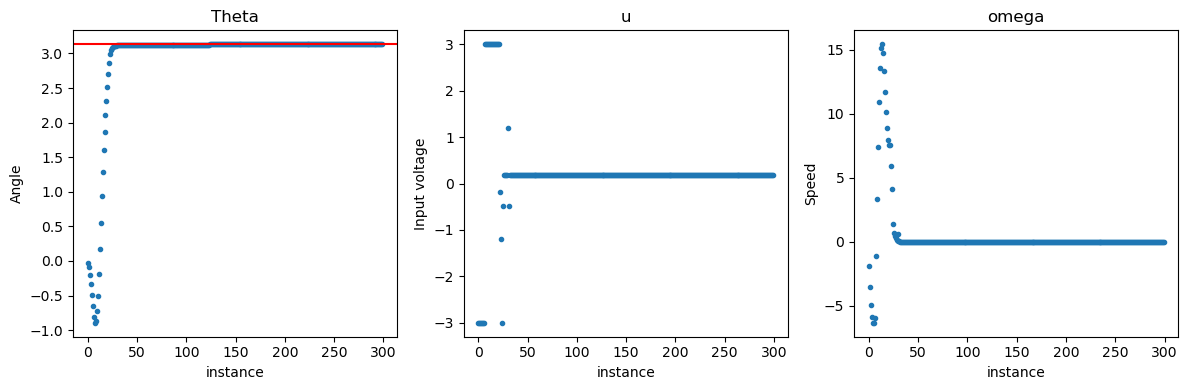

In [10]:
# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot theta
axs[0].plot(theta, '.')
axs[0].set_title('Theta')
axs[0].set_xlabel('instance')
axs[0].set_ylabel('Angle')
axs[0].axhline(y=target_angle, color='r', linestyle='-')

# Plot u
axs[1].plot(u, '.')
axs[1].set_title('u')
axs[1].set_xlabel('instance')
axs[1].set_ylabel('Input voltage')

# Plot omega
axs[2].plot(omega, '.')
axs[2].set_title('omega')
axs[2].set_xlabel('instance')
axs[2].set_ylabel('Speed')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

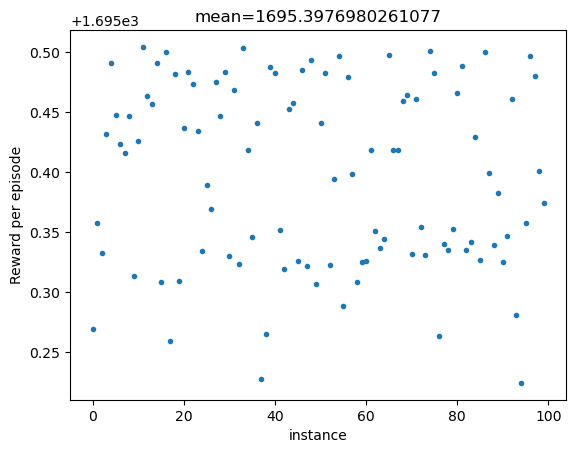

Saved Qfunction in Qfunction


In [11]:
from matplotlib import pyplot as plt
Rewards = [eval_Q(Q,env) for i in range(100)]
plt.plot(Rewards,'.')
plt.title(f'mean={np.mean(Rewards)}')
plt.xlabel('instance')
plt.ylabel('Reward per episode')
plt.show()

if np.mean(Rewards) > 1600:
    save_Qfunction(Q)